<a href="https://colab.research.google.com/github/aravind598/FYP/blob/main/Copy_of_TADNE_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import torch

TensorFlow 1.x selected.


# Install CLIP

In [ ]:
! wget "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt" -O clip.pt
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
! clear

--2022-06-01 17:43:08--  https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 934088680 (891M) [application/octet-stream]
Saving to: ‘clip.pt’

clip.pt             100%[===================>] 890.82M  26.9MB/s    in 94s     

2022-06-01 17:44:41 (9.52 MB/s) - ‘clip.pt’ saved [934088680/934088680]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-01 17:44:46--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to openaipublic.azure

In [ ]:
### run

clip = torch.jit.load("clip.pt").cuda().eval()

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


# Image Preprocessing

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# This Anime Does Not Exist

This notebook generates interpolation videos from the model used for https://thisanimedoesnotexist.ai by [@aydao](https://aydao.ai).

Notebook by [@arfa](https://twitter.com/arfafax).

---




In [ ]:
%cd /content
!git clone https://github.com/shawwn/stylegan2 -b estimator /content/stylegan2
import gdown
gdown.download('https://drive.google.com/uc?id=1LCkyOPmcWBsPlQX_DxKAuPM1Ew_nh83I', 'network-tadne.pkl', quiet=False)

/content
Cloning into '/content/stylegan2'...
remote: Enumerating objects: 1463, done.
remote: Total 1463 (delta 0), reused 0 (delta 0), pack-reused 1463
Receiving objects: 100% (1463/1463), 932.46 KiB | 11.37 MiB/s, done.
Resolving deltas: 100% (1045/1045), done.


Downloading...
From: https://drive.google.com/uc?id=1LCkyOPmcWBsPlQX_DxKAuPM1Ew_nh83I
To: /content/network-tadne.pkl
100%|██████████| 1.06G/1.06G [00:09<00:00, 110MB/s]


'network-tadne.pkl'

In [ ]:
%cd /content/stylegan2
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import scipy

/content/stylegan2


In [ ]:
tflib.init_tf()
_G, _D, Gs = pickle.load(open("/content/stylegan2/network-tadne.pkl", "rb"))

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
random_seed = 0
np.random.seed(random_seed)
codes = np.random.randn(1, 1024)
rs=Gs.components.mapping.run(codes,None)

In [ ]:
rs

array([[[-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796],
        [-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796],
        [-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796],
        ...,
        [-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796],
        [-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796],
        [-0.06109855,  0.90811825, -0.06974419, ...,  0.5655962 ,
         -0.03883243, -0.38850796]]], dtype=float32)

In [ ]:
#Gs.__getstate__().keys()
#open('build_module_src.py','w').write(Gs.__getstate__()['build_module_src'])
Gs.__getstate__()['components']['mapping'].print_layers()

# convert NVlabs/stylegan2-ada-pytorch

In [ ]:
%cd /content
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd /content/stylegan2-ada-pytorch
!pip install ninja

In [ ]:
%cd /content
!git clone https://github.com/dvschultz/stylegan2-ada-pytorch
%cd /content/stylegan2-ada-pytorch
!pip install ninja

/content
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 533, done.
remote: Total 533 (delta 0), reused 0 (delta 0), pack-reused 533
Receiving objects: 100% (533/533), 8.41 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (304/304), done.
/content/stylegan2-ada-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 5.2 MB/s 


In [ ]:
!python legacy.py \
        --source=/content/network-tadne.pkl \
        --dest=/content/network-tadne.pt.pkl


Loading "/content/network-tadne.pkl"...
Unknown TensorFlow data! This may result in problems with your converted model.
['resolution_h', 'resolution_w']
Unknown TensorFlow data! This may result in problems with your converted model.
['resolution_h', 'resolution_w']
Unknown TensorFlow data! This may result in problems with your converted model.
['resolution_h', 'resolution_w']
Saving "/content/network-tadne.pt.pkl"...
Done.


In [ ]:
import pickle
import numpy as np
import torch
import PIL
device="cuda"
network_pkl = '/content/network-tadne.pt.pkl'
with open(network_pkl, 'rb') as f:
    aio = pickle.load(f)
    G = aio["G_ema"].cuda()
    D = aio["D"].cuda()
    #G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
#z = torch.randn([1, G.z_dim]).cuda()    # latent codes
#z=torch.from_numpy(np.random.RandomState(seed).randn(1, 1024)).to(device)
#c = None                                # class labels (not used in this example)
#img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
#img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'/content/frame1.png')

In [ ]:
z=torch.from_numpy(np.random.RandomState(0).randn(1, 1024)).to(device)
c = None                                # class labels (not used in this example)
img = G(z, c, truncation_psi=0.5,noise_mode="const")                           # NCHW, float32, dynamic range [-1, +1]
#img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
img=img.cpu().numpy()
score1 = D(torch.from_numpy(img).cuda(),c)
print(score1)

tensor([[-3.6931]], device='cuda:0')


In [ ]:
%cd /content/stylegan2-ada-pytorch
import dnnlib
import legacy
import PIL
network_pkl = '/content/network-tadne.pt.pkl'
device = "cuda"

with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    #D = legacy.load_network_pkl(f)['D'].to(device)

inputSize=1024
seed = 0
z = torch.from_numpy(np.random.RandomState(seed).randn(1, 1024)).to(device)
label = torch.zeros([1, G.c_dim], device=device)

/content/stylegan2-ada-pytorch


In [ ]:
def images(G,device,inputs,space,truncation_psi,label,noise_mode,outdir,start=None,stop=None):
    for idx, i in enumerate(inputs):
        print('Generating image for frame %d/%d ...' % (idx, len(inputs)))
        
        if (space=='z'):
            z = torch.from_numpy(np.random.RandomState(seed).randn(1, 1024)).to(device)
            if(start is not None and stop is not None):
                img = G(z, label, truncation_psi=tp, noise_mode=noise_mode)
            else:
                img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        else:
            if i.shape[0] == 18: 
              i = torch.from_numpy(i).unsqueeze(0).to(device)
            img = G.synthesis(i, noise_mode=noise_mode, force_fp32=True)
        
        print(img.size())
        score=D(img,c=None)
        print(score)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/frame{idx:04d}.png')

In [ ]:
label = torch.zeros([1, G.c_dim], device="cuda")
seed=0
images(G,"cuda",[0],"z",0.5,label,noise_mode="const",outdir="/content/")

Generating image for frame 0/1 ...
torch.Size([1, 3, 512, 512])
tensor([[-3.6931]], device='cuda:0')


In [ ]:
!python generate.py --outdir=out --trunc=0.9 --seeds=35363 \
    --network=/content/network-tadne.pt.pkl

Loading networks from "/content/network-tadne.pt.pkl"...
Generating image for seed 35363 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
%cd /content/
!git clone https://github.com/openai/CLIP.git
%rm /content/CLIP/requirements.txt
from google.colab import files
with open('/content/CLIP/requirements.txt', 'w') as f: f.write('ftfy')

!pip install /content/CLIP/

import clip
import torch

# Load the openAI CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

/content
Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./CLIP
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369366 sha256=91b78e225bf7803822c7c8f2c57ed6a1817a9412e5ebe33bcfad52a63427707e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0xx0tdtx/wheels/9e/b0/5b/75abd9d449df0da019011d4fd

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.4MiB/s]


In [ ]:
%cd /content/stylegan2-ada-pytorch
!python pbaylies_projector.py --network '/content/network-tadne.pt.pkl' --outdir '/content/out/'

In [ ]:
%cd /content/stylegan2-ada-pytorch
!python export_weights.py /content/network-tadne.pt.pkl /content/network-tadne.pt

/content/stylegan2-ada-pytorch


In [ ]:
!rm -rf /content/stylegan2-pytorch

In [ ]:
%cd /content

In [ ]:
%cd /content
!git clone https://github.com/rosinality/stylegan2-pytorch
%cd /content/stylegan2-pytorch/

/content
Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395
Receiving objects: 100% (395/395), 122.51 MiB | 38.75 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/stylegan2-pytorch


In [ ]:
%cd /content/stylegan2-pytorch/
!python generate.py --size 512 --pics 20 --ckpt /content/network-tadne.pt --truncation 0.5

/content/stylegan2-pytorch
  0% 0/20 [00:00<?, ?it/s]/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.11.0+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
100% 20/20 [00:03<00:00,  5.28it/s]


In [ ]:
ckpt=torch.load('/content/network-tadne.pt')

dict_keys(['g_ema', 'latent_avg'])


# convert_weight rosinality

In [ ]:
!git clone https://github.com/rosinality/stylegan2-pytorch /content/stylegan2-pytorch
!pip install ninja

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Cloning into '/content/stylegan2-pytorch'...
fatal: Unable to read current working directory: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
%cd /content/stylegan2-pytorch
!python convert_weight.py --repo /content/stylegan2 /content/network-tadne.pkl

/content/stylegan2-pytorch


attach_debugger <function attach_debugger at 0x7f36a778da70>
print_status <function print_status at 0x7f36a778db00>
freeze_forever <function freeze_forever at 0x7f36a778dcb0>
quit <function quit at 0x7f36a778dd40>
save_and_quit <function save_and_quit at 0x7f36a778de60>
throw_exception <function throw_exception at 0x7f36a778def0>
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Traceback (most recent call last):
  File "convert_weight.py", line 241, in <module>
    mapping_layers_names = g_ema.__getstate__()['components']['mapping'].list_layers()
  File "/content/stylegan2/dnnlib/tflib/network.py", line 530, in list_layers
    recurse(self.scope, self.list_ops(), list(self.vars.items()), 0)
  File "/content/stylegan2/dnnlib/tflib/network.py", line 520, in recurse
    recurse(global_prefix + token, cur_ops, cur_vars, le

In [ ]:
import torch
from torchvision import utils
from model import Generator
import numpy as np

ckpt = torch.load('network-tadne.pt')

device = 'cuda' # cpu

g = Generator(512, 1024, 4).to(device)
g.load_state_dict(ckpt["g_ema"], strict=False)

In [ ]:
g

In [ ]:
 for k in g.state_dict().keys():
    print(k)

In [ ]:
seed = 35363
psi = 0.3

trunc = g.mean_latent(4096)
latent = torch.from_numpy(np.random.RandomState(seed).randn(1024)).unsqueeze(0)
latent = torch.tensor(latent,dtype=torch.float32).to(device)
    
with torch.no_grad():
  latent = g.get_latent(latent)
  img0, _ = g(
      [latent],
      truncation=psi,
      truncation_latent=trunc,
      input_is_latent=True,
  )
utils.save_image(
  torch.cat([img0], 0),
  f"{seed}.png",
  #normalize=True,
  #range=(-1, 1),
  nrow=1,
)

In [ ]:
!python generate.py --sample 1 --pics 1 --ckpt network-tadne.pt

In [ ]:
!python TADNE.py --ckpt network-tadne.pt

In [ ]:
!ls -hl

In [ ]:
!cp /content/stylegan2-pytorch/network-tadne.pt /content/drive/MyDrive

score_latents from [@nagolinc](https://github.com/nagolinc/notebooks/blob/main/TADNE_and_CLIP.ipynb)

In [ ]:
# Image prepro for CLIP
input_resolution = clip.input_resolution.item()
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

# unit random, i fully trust that this random stackoverflow guys math checks out
def random_unit(dims):
    vec = [np.random.randn() for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return np.array([x/mag for x in vec])

# We have to do truncation ourselves, since we're not using the combined network
def truncate(dlatents, truncation_psi, maxlayer = 16):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(16)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

# dlatent image generator
def generate_image_from_dlatents(dlatents, mb_size = 10, truncation_psi = None, randomize_noise = True):
    dlatents = np.array(dlatents)
    if not truncation_psi is None:
        dlatents_trunc = truncate(dlatents, truncation_psi)
    else:
        dlatents_trunc = dlatents

    # Run the network
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_images = Gs.components.synthesis.run(
        dlatents_trunc,
        randomize_noise = randomize_noise,
        minibatch_size = min(mb_size, dlatents_trunc.shape[0]),
        output_transform=fmt
    )
    return result_images
    
# latents -> dlatents (just run the mapping network)
def get_dlatents(latents):
   return Gs.components.mapping.run(latents.reshape(-1, latents.shape[-1]), None)

# Generate text embedding
def embed_text(text):
    tokenizer = SimpleTokenizer(bpe_path="/content/bpe_simple_vocab_16e6.txt.gz")
    text_tokens = [tokenizer.encode(text)]
    text_input = torch.zeros(len(text_tokens), clip.context_length, dtype=torch.long)

    for i, tokens in enumerate(text_tokens):
        text_input[i, :len(tokens)] = torch.tensor(tokens)

    text_input = text_input.cuda()
    with torch.no_grad():
      text_features = clip.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    return text_features.cpu().numpy()

# Scoring for latents
def score_latents(latents_in, truncation_psi, text_embed, mb_size = 10, l2_regu_weight = 0.01):
    dlatents = get_dlatents(latents_in)
    score_list = []

    # Generate some images
    images_in = generate_image_from_dlatents(dlatents, truncation_psi = truncation_psi, randomize_noise = False)
    images_in = [preprocess(PIL.Image.fromarray(img, 'RGB')) for img in images_in]

    for i in range(0, len(dlatents), mb_size):
        images = images_in[i:i + mb_size]
        latents = latents_in[i:i + mb_size]
        image_input = torch.tensor(np.stack(images)).cuda()
        image_input -= image_mean[:, None, None]
        image_input /= image_std[:, None, None]
        
        with torch.no_grad():
            image_features = clip.encode_image(image_input).float()

        # compute similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = text_embed @ image_features.cpu().numpy().T
        score = similarity[0]
        # Regularize
        if not l2_regu_weight is None:
            l2_regu = (np.sqrt(np.mean(np.square(latents), axis = -1, keepdims = True)) * l2_regu_weight)[:, 0]
            print("scores", score, ", regu scores", l2_regu)
            score = score - l2_regu
        score_list.extend(score)
    return np.array(score_list)


# convert_weight genforce

In [ ]:
!git clone https://github.com/huaji0353/higan /content/stylegan2-genforce

In [ ]:
%cd /content/stylegan2-genforce/
!python synthesize.py stylegan2_TADNE  --output_dir=stylegan2_TADNE  --num=1  --generate_prediction

In [ ]:
!rm /content/stylegan2-genforce/models/pretrain/pytorch/0_stylegan2_TADNE.pth

In [ ]:
from collections import OrderedDict
import torch

# find \higan-master\models\pretrain\pytorch\0_stylegan2_animeportrait512.pth
state_dict = torch.load('/content/stylegan2-genforce/models/pretrain/pytorch/0_stylegan2_TADNE.pth')

# https://github.com/genforce/sefa/issues/3#issuecomment-740504792
# ADD remove .fc

for i in range(0,4):
    state_dict[f'mapping.dense{i}.weight'] = state_dict[f'mapping.dense{i}.fc.weight'].permute(0,1)
    del(state_dict[f'mapping.dense{i}.fc.weight'])

for i in range(0,15):
    state_dict[f'synthesis.layer{i}.weight'] = state_dict[f'synthesis.layer{i}.weight'].permute(3, 2, 0, 1)
    state_dict[f'synthesis.layer{i}.style.weight'] = state_dict[f'synthesis.layer{i}.style.fc.weight']
    del(state_dict[f'synthesis.layer{i}.style.fc.weight'])

for i in range(0,8):
    state_dict[f'synthesis.output{i}.weight'] = state_dict[f'synthesis.output{i}.weight'].permute(3, 2, 0, 1)
    state_dict[f'synthesis.output{i}.style.weight'] = state_dict[f'synthesis.output{i}.style.fc.weight']
    del(state_dict[f'synthesis.output{i}.style.fc.weight'])

# torch.save(state_dict, "stylegan2_animeportrait512.pth")
# genforce warp ['generator'] 
new_state_dict = OrderedDict()
new_state_dict['generator'] = state_dict
torch.save(new_state_dict, "stylegan2_TADNE.pth")


## test

In [ ]:
import numpy as np
import cv2
import PIL.Image
import torch

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  PIL.Image.fromarray(fused_image).save('imshow.jpg')

def postprocess(images):
  """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
  images = images.detach().cpu().numpy()
  images = (images + 1) * 255 / 2
  images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
  images = images.transpose(0, 2, 3, 1)
  return images

In [ ]:
%cd /content/stylegan2-genforce

### code 1

In [ ]:
from models.TADNE import TADNEGeneratorNet
#from models.stylegan2_generator import StyleGAN2Generator

checkpoint = torch.load('/content/stylegan2-genforce/models/pretrain/pytorch/0_stylegan2_TADNE.pth', map_location='cuda')
#checkpoint = torch.load('/content/stylegan2-genforce/stylegan2_TADNE.pth', map_location='cuda')

checkpoint['truncation.truncation'] = torch.randn(1, 16, 1)

generator = TADNEGeneratorNet().to('cuda')
#generator = StyleGAN2Generator('stylegan2_TADNE').to('cuda')

generator.load_state_dict(checkpoint)
generator.eval()

# np.random.seed(random_seed)
# codes = np.random.randn(1, 1024)
# generator.mapping(torch.from_numpy(codes).type(torch.FloatTensor).to('cuda'))

num_samples = 1
random_seed = 35363
np.random.seed(random_seed)

with torch.no_grad():
  zcodes = torch.from_numpy(np.random.randn(num_samples, generator.z_space_dim)).type(torch.FloatTensor).to('cuda')
  images = generator(zcodes)
imshow(postprocess(images), col=num_samples)

In [ ]:
generator.mapping.dense0(torch.from_numpy(codes).type(torch.FloatTensor).to('cuda'))

In [ ]:
!ls -hl /content/stylegan2-genforce/models/pretrain/pytorch

# visualization utility

In [ ]:
# Original code from nvidia repo, yoinked over here for quicker editing and fixing -- @halcy
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import copy
import PIL.Image

import numpy as np
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib

from training import misc


# halcy clip

### gaussian_opt from [@halcy colab](https://colab.research.google.com/drive/1p03gWLGgQU7IAY44O1_vWnIPN_D0o9_v)

In [ ]:
# Added by @halcy, based on @nagolinc's original notebook: Fitting sampling distributions
# for a CLIP embedding

# Just calculates mean and covariance
def gaussian_mle(samples):
    samples = np.array(samples).reshape(np.array(samples).shape[0], -1)
    mean = np.mean(np.array(samples), axis = 0)
    cov = np.cov(np.array(samples).T)
    return mean, cov

# Iteratively find a multivariate gaussian that optimizes for a specific CLIP embedding
# Works fairly well for "common" features. Fails utterly for rare features, because
# when it can't find any instances, what can it do, really?
# TODO: momentum might help with variety to some extent
# TODO: it might be cool to instead look at the dlatent space / post mapping space for variety (not for sampling with a gaussian, though)
# TODO: could also fit different distributions (gauss mix with n = ? gaussians?)
# TODO: regularize with discriminator?
# TODO: How can we make more complex descriptions / combinations work better / at all? Possibly optimize separately?
# TODO: repeat the initial sample if we don't have at least a 95th percentile score of such and such?
# TODO: add an image similarity loss. "image that looks like this and also fits the description".
def gaussian_opt(initial_latents, text_embed, initial_cov = 3.0, var_target = None, batch_initial = 500, batch_reduce = 0.75, batch_min = 50, nbest_fact = 0.05, nbest_min = 10, iters = 20, truncation_psi = 1.2, show_steps = False, l2_regu_weight = None):
    mean_hist = []
    cov_hist = []
    batch_current = batch_initial

    current_mean = initial_latents.flatten()
    current_cov = np.eye(len(initial_latents.flatten())) * initial_cov # TODO allow actually giving a full matrix so you can resume, right now it just starts at full diagonal
    latent_nbest = []
    latent_nbest_scores = []

    for i in range(iters):
        # Keep track of progress
        print("Iter", i)
        mean_hist.append(current_mean)
        cov_hist.append(current_cov)

        # Generate examples after every iteration - useful for debugging
        if show_steps == True:
          sampled_latents = np.random.multivariate_normal(current_mean, current_cov, 9)
          sampled_latents = sampled_latents.reshape(sampled_latents.shape[0], latents.shape[0], latents.shape[1])
          images = generate_image_from_dlatents(get_dlatents(sampled_latents), truncation_psi = truncation_psi)    

          plt.figure(figsize=(8, 8))
          for j in range(9):
              plt.subplot(3, 3, j + 1)
              plt.imshow(images[j])
          plt.show()

        # Pick and score new latents 
        new_latents = np.random.multivariate_normal(current_mean, current_cov, batch_current)
        scores = score_latents(new_latents, truncation_psi, text_embed, l2_regu_weight = l2_regu_weight)
        latent_nbest_scores.extend(scores)
        latent_nbest.extend(new_latents)

        # Find the best latents after update
        #nbest = max(int(batch_current * nbest_fact), nbest_min)
        nbest = 10
        best_idx = np.argsort(np.array(latent_nbest_scores).flatten())[-nbest:]
        latent_nbest = list(np.array(latent_nbest)[best_idx])
        latent_nbest_scores = list(np.array(latent_nbest_scores)[best_idx])

        # Reestimate gaussian
        current_mean, current_cov = gaussian_mle(latent_nbest)
        
        # Reduce batch size
        batch_current = max(int(batch_current * batch_reduce), batch_min)

        # Force the sum variance to be at least as much as a diagonal covariance matrix times var_target
        # * TODO: other norms? Something a bit smarter? results thus far best with l1, which matches expectations to some extent (sum regularization should lead to a selection effect - TODO verify this)
        # * TODO: Momentum?
        # Notes: 
        # 1) Overall sum / l1 leads to samples becoming weird, not even neccesarily good. It might be best to focus on the diagonal.
        # 2) RMS / l2 doesn't really work all that well
        # 3) Variant 3 seems best so far, but tends to go "off clip." - a regularization term for the latents helps
        if not var_target is None:
          """
          # Variant 1: Sum, whole matrix, scale whole matrix
          cov_sum = np.sum(current_cov)
          if cov_sum < current_cov.shape[0] * var_target:
              current_cov = (current_cov / cov_sum) * current_cov.shape[0] * var_target
          """
          """
          # Variant 1.5: Weird intermediate variant, scale all but only when the diagonal sum is too small
          cov_sum = np.sum(np.diag(current_cov))
          if cov_sum < current_cov.shape[0] * var_target:
              current_cov = (current_cov / np.sum(current_cov)) * current_cov.shape[0] * var_target
          print("cov sum:", cov_sum)
          """
          """
          # Variant 2: Sum, diagonal only but scale all
          cov_sum = np.sum(np.diag(current_cov))
          if cov_sum < current_cov.shape[0] * var_target:
              current_cov = (current_cov / cov_sum) * current_cov.shape[0] * var_target
          print("cov sum:", cov_sum)
          """
          # Variant 3: Sum, diagonal only, scale diagonal only
          # Trying this with the same target as the other variants (3.0) doesn't work too well, maybe needs less?
          # l2 regu on the latents slows convergence but reins it in somewhat
          cov_sum = np.sum(np.diag(current_cov))
          if cov_sum < current_cov.shape[0] * var_target:
              diag_indices = np.diag_indices_from(current_cov)
              current_cov[diag_indices] = (current_cov[diag_indices] / cov_sum) * current_cov.shape[0] * var_target
          print("cov sum:", cov_sum)
          """
          # Variant 4: root mean square, diagonal only, scale diagonal only
          # Not very good, results in kind of boring samples, l1 is probably the way to go
          cov_rms = np.sqrt(np.sum(np.square(np.diag(current_cov))))
          if cov_rms < np.sqrt(current_cov.shape[0]) * var_target:
              diag_indices = np.diag_indices_from(current_cov)
              current_cov[diag_indices] = (current_cov[diag_indices] / cov_rms) * np.sqrt(current_cov.shape[0]) * var_target
          print("cov rms:", cov_rms)
          """
    return current_mean, current_cov, mean_hist, cov_hist


In [ ]:
# latents = np.random.RandomState(69).randn(1, Gs.input_shape[1]) * 0.001
# text_embed = embed_text("A picture of a girl wearing glasses")
# mean, cov, mhist, chist = gaussian_opt(
#     latents, 
#     text_embed, 
#     show_steps = True, 
#     var_target = 0.75,
#     batch_initial = 100,
#     batch_min = 50,
#     iters = 10,
#     truncation_psi = 0.8,
#     l2_regu_weight = 0.03
# )
latents = np.random.RandomState(64).randn(1, Gs.input_shape[1]) * 0.001
text_embed = embed_text("A High quality picture of girl ")
mean, cov, mhist, chist = gaussian_opt(
    latents, 
    text_embed, 
    show_steps = True, 
    var_target = 0.2,
    batch_initial = 20,
    batch_min = 10,
    iters = 10,
    truncation_psi = 0.6,
    l2_regu_weight = 0.01
)

In [ ]:
# just from optimize geted mean cov to sample bunch of similar images

sampled_latents = np.random.multivariate_normal(mean, cov, 16)
sampled_latents = sampled_latents.reshape(sampled_latents.shape[0], latents.shape[0], latents.shape[1])
images = generate_image_from_dlatents(get_dlatents(sampled_latents), truncation_psi = 0.8)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
plt.show()


# pytorch HighCWu

In [ ]:
!pip install ninja
!git clone https://github.com/HighCWu/stylegan2-pytorch2paddle -b tadne /content/stylegan2-pytorch
%cd /content/stylegan2-pytorch
import gdown
gdown.download('https://drive.google.com/uc?id=1MnBuwQzljoFqdQBGFcg-EmT2h73dTQPR', 'network-tadne.pt', quiet=False)

In [ ]:
!mv /content/GANLatentDiscovery/network-tadne.pt /content/navigan

In [ ]:
!python generate.py

In [ ]:
%cd /content/stylegan2-pytorch

# GANLatentDiscovery

In [ ]:
%cd /content
!git clone https://github.com/anvoynov/GANLatentDiscovery
%cd /content/GANLatentDiscovery
!pip install tensorboardX

/content
Cloning into 'GANLatentDiscovery'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 214 (delta 35), reused 28 (delta 28), pack-reused 161
Receiving objects: 100% (214/214), 2.63 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/GANLatentDiscovery
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.2 MB/s 


In [ ]:
#gan_load L110 StyleGAN2Generator(512, 1024, 4, channel_multiplier=2)
#L51 self.dim_z = 1024
!cp /content/stylegan2-pytorch/model.py /content/GANLatentDiscovery/models/StyleGAN2
#from models.StyleGAN2.op 

In [ ]:
#%cd /content/GANLatentDiscovery/models/StyleGAN2
!cp -r /content/stylegan2-pytorch/op /content/GANLatentDiscovery/models/StyleGAN2/op

In [ ]:
!rm -rf /content/GANLatentDiscovery/op

In [ ]:
%cd /content/GANLatentDiscovery

/content/GANLatentDiscovery


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# trainer self.batch_size = 4
!python /content/GANLatentDiscovery/run_train.py \
    --seed 35363 \
    --out exp02_dir \
    --gan_type StyleGAN2  \
    --gan_weights '/content/network-tadne.pt' \
    --deformator id \
    --shift_predictor ResNet \
    --shift_distribution_key normal \
    --w_shift False \
    --gan_resolution 512

In [ ]:
%cd /content
!git clone https://github.com/yandex-research/navigan
%cd /content/navigan

/content
Cloning into 'navigan'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 175 (delta 4), reused 0 (delta 0), pack-reused 169
Receiving objects: 100% (175/175), 38.06 MiB | 35.95 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/navigan


In [ ]:
#gan_load L110 StyleGAN2Generator(512, 1024, 4, channel_multiplier=2)
#L51 self.dim_z = 1024
!mv /content/navigan/models/StyleGAN2/model.py /content/navigan/models/StyleGAN2/model-0.py
!cp /content/GANLatentDiscovery/models/StyleGAN2/model.py /content/navigan/models/StyleGAN2/model.py
# from models.StyleGAN2.op 

In [ ]:
!cp -r /content/stylegan2-pytorch/op /content/navigan/

In [ ]:
!python run_train.py \
    --out exp000_dir \
    --gan_type StyleGAN2 \
    --gan_weights '/content/network-tadne.pt' \
    --resolution 512 \
    --shift_predictor_size 256 \
    --deformator_target weight_svd \
    --deformator_conv_layer_index 3 \
    --directions_count 64 \
    --shift_scale 3500 \
    --shift_weight 0.0025 \
    --min_shift 300 \
#model .ModulatedConv2dPatchedFixedBasisDelta expand_to_bach

### Model.py for navigan

In [ ]:
# import math
# import random
# import functools
# import operator

# import torch
# from torch import nn
# from torch.nn import functional as F
# from torch.autograd import Function
# import numpy as np
# from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix


# def expand_to_bach(value, batch_size, target_type):
#     try:
#         assert value.shape[0] == batch_size, f'batch size is not equal to the tensor size'
#     except Exception:
#         value = value * torch.ones(batch_size, dtype=target_type)
#     return value.to(target_type)

# class PixelNorm(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, input):
#         return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


# def make_kernel(k):
#     k = torch.tensor(k, dtype=torch.float32)

#     if k.ndim == 1:
#         k = k[None, :] * k[:, None]

#     k /= k.sum()

#     return k


# class Upsample(nn.Module):
#     def __init__(self, kernel, factor=2):
#         super().__init__()

#         self.factor = factor
#         kernel = make_kernel(kernel) * (factor ** 2)
#         self.register_buffer("kernel", kernel)

#         p = kernel.shape[0] - factor

#         pad0 = (p + 1) // 2 + factor - 1
#         pad1 = p // 2

#         self.pad = (pad0, pad1)

#     def forward(self, input):
#         out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

#         return out


# class Downsample(nn.Module):
#     def __init__(self, kernel, factor=2):
#         super().__init__()

#         self.factor = factor
#         kernel = make_kernel(kernel)
#         self.register_buffer("kernel", kernel)

#         p = kernel.shape[0] - factor

#         pad0 = (p + 1) // 2
#         pad1 = p // 2

#         self.pad = (pad0, pad1)

#     def forward(self, input):
#         out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

#         return out


# class Blur(nn.Module):
#     def __init__(self, kernel, pad, upsample_factor=1):
#         super().__init__()

#         kernel = make_kernel(kernel)

#         if upsample_factor > 1:
#             kernel = kernel * (upsample_factor ** 2)

#         self.register_buffer("kernel", kernel)

#         self.pad = pad

#     def forward(self, input):
#         out = upfirdn2d(input, self.kernel, pad=self.pad)

#         return out


# class EqualConv2d(nn.Module):
#     def __init__(
#         self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
#     ):
#         super().__init__()

#         self.weight = nn.Parameter(
#             torch.randn(out_channel, in_channel, kernel_size, kernel_size)
#         )
#         self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

#         self.stride = stride
#         self.padding = padding

#         if bias:
#             self.bias = nn.Parameter(torch.zeros(out_channel))

#         else:
#             self.bias = None

#     def forward(self, input):
#         out = conv2d_gradfix.conv2d(
#             input,
#             self.weight * self.scale,
#             bias=self.bias,
#             stride=self.stride,
#             padding=self.padding,
#         )

#         return out

#     def __repr__(self):
#         return (
#             f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
#             f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
#         )


# class EqualLinear(nn.Module):
#     def __init__(
#         self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
#     ):
#         super().__init__()

#         self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

#         if bias:
#             self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

#         else:
#             self.bias = None

#         self.activation = activation

#         self.scale = (1 / math.sqrt(in_dim)) * lr_mul
#         self.lr_mul = lr_mul

#     def forward(self, input):
#         if self.activation:
#             out = F.linear(input, self.weight * self.scale)
#             out = fused_leaky_relu(out, self.bias * self.lr_mul)

#         else:
#             out = F.linear(
#                 input, self.weight * self.scale, bias=self.bias * self.lr_mul
#             )

#         return out

#     def __repr__(self):
#         return (
#             f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
#         )


# class ModulatedConv2d(nn.Module):
#     def __init__(
#         self,
#         in_channel,
#         out_channel,
#         kernel_size,
#         style_dim,
#         demodulate=True,
#         upsample=False,
#         downsample=False,
#         blur_kernel=[1, 3, 3, 1],
#         fused=True,
#     ):
#         super().__init__()

#         self.eps = 1e-8
#         self.kernel_size = kernel_size
#         self.in_channel = in_channel
#         self.out_channel = out_channel
#         self.upsample = upsample
#         self.downsample = downsample

#         if upsample:
#             factor = 2
#             p = (len(blur_kernel) - factor) - (kernel_size - 1)
#             pad0 = (p + 1) // 2 + factor - 1
#             pad1 = p // 2 + 1

#             self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

#         if downsample:
#             factor = 2
#             p = (len(blur_kernel) - factor) + (kernel_size - 1)
#             pad0 = (p + 1) // 2
#             pad1 = p // 2

#             self.blur = Blur(blur_kernel, pad=(pad0, pad1))

#         fan_in = in_channel * kernel_size ** 2
#         self.scale = 1 / math.sqrt(fan_in)
#         self.padding = kernel_size // 2

#         self.weight = nn.Parameter(
#             torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
#         )

#         self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

#         self.demodulate = demodulate
#         self.fused = fused

#     def __repr__(self):
#         return (
#             f"{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, "
#             f"upsample={self.upsample}, downsample={self.downsample})"
#         )

#     def forward(self, input, style):
#         batch, in_channel, height, width = input.shape

#         if not self.fused:
#             weight = self.scale * self.weight.squeeze(0)
#             style = self.modulation(style)

#             if self.demodulate:
#                 w = weight.unsqueeze(0) * style.view(batch, 1, in_channel, 1, 1)
#                 dcoefs = (w.square().sum((2, 3, 4)) + 1e-8).rsqrt()

#             input = input * style.reshape(batch, in_channel, 1, 1)

#             if self.upsample:
#                 weight = weight.transpose(0, 1)
#                 out = conv2d_gradfix.conv_transpose2d(
#                     input, weight, padding=0, stride=2
#                 )
#                 out = self.blur(out)

#             elif self.downsample:
#                 input = self.blur(input)
#                 out = conv2d_gradfix.conv2d(input, weight, padding=0, stride=2)

#             else:
#                 out = conv2d_gradfix.conv2d(input, weight, padding=self.padding)

#             if self.demodulate:
#                 out = out * dcoefs.view(batch, -1, 1, 1)

#             return out

#         style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
#         weight = self.scale * self.weight * style

#         if self.demodulate:
#             demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
#             weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

#         weight = weight.view(
#             batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
#         )

#         if self.upsample:
#             input = input.view(1, batch * in_channel, height, width)
#             weight = weight.view(
#                 batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
#             )
#             weight = weight.transpose(1, 2).reshape(
#                 batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
#             )
#             out = conv2d_gradfix.conv_transpose2d(
#                 input, weight, padding=0, stride=2, groups=batch
#             )
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)
#             out = self.blur(out)

#         elif self.downsample:
#             input = self.blur(input)
#             _, _, height, width = input.shape
#             input = input.view(1, batch * in_channel, height, width)
#             out = conv2d_gradfix.conv2d(
#                 input, weight, padding=0, stride=2, groups=batch
#             )
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         else:
#             input = input.view(1, batch * in_channel, height, width)
#             out = conv2d_gradfix.conv2d(
#                 input, weight, padding=self.padding, groups=batch
#             )
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         return out


# class NoiseInjection(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.weight = nn.Parameter(torch.zeros(1))

#     def forward(self, image, noise=None):
#         if noise is None:
#             batch, _, height, width = image.shape
#             noise = image.new_empty(batch, 1, height, width).normal_()

#         return image + self.weight * noise


# class ConstantInput(nn.Module):
#     def __init__(self, channel, size=4):
#         super().__init__()

#         self.input = nn.Parameter(torch.randn(1, channel, size, size))

#     def forward(self, input):
#         batch = input.shape[0]
#         out = self.input.repeat(batch, 1, 1, 1)

#         return out


# class StyledConv(nn.Module):
#     def __init__(
#         self,
#         in_channel,
#         out_channel,
#         kernel_size,
#         style_dim,
#         upsample=False,
#         blur_kernel=[1, 3, 3, 1],
#         demodulate=True,
#     ):
#         super().__init__()

#         self.conv = ModulatedConv2d(
#             in_channel,
#             out_channel,
#             kernel_size,
#             style_dim,
#             upsample=upsample,
#             blur_kernel=blur_kernel,
#             demodulate=demodulate,
#         )

#         self.noise = NoiseInjection()
#         # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
#         # self.activate = ScaledLeakyReLU(0.2)
#         self.activate = FusedLeakyReLU(out_channel)

#     def forward(self, input, style, noise=None):
#         out = self.conv(input, style)
#         out = self.noise(out, noise=noise)
#         # out = out + self.bias
#         out = self.activate(out)

#         return out


# class ToRGB(nn.Module):
#     def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
#         super().__init__()

#         if upsample:
#             self.upsample = Upsample(blur_kernel)

#         self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
#         self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

#     def forward(self, input, style, skip=None):
#         out = self.conv(input, style)
#         out = out + self.bias

#         if skip is not None:
#             skip = self.upsample(skip)

#             out = out + skip

#         return out


# class Generator(nn.Module):
#     def __init__(
#         self,
#         size,
#         style_dim,
#         n_mlp,
#         channel_multiplier=2,
#         additional_multiplier=2,
#         blur_kernel=[1, 3, 3, 1],
#         lr_mlp=0.01,
#     ):
#         super().__init__()

#         self.size = size

#         self.style_dim = style_dim

#         layers = [PixelNorm()]

#         for i in range(n_mlp):
#             layers.append(
#                 EqualLinear(
#                     style_dim, style_dim, lr_mul=lr_mlp, activation="fused_lrelu"
#                 )
#             )

#         self.style = nn.Sequential(*layers)

#         self.channels = {
#             4: 512,
#             8: 512,
#             16: 512,
#             32: 512,
#             64: 256 * channel_multiplier,
#             128: 128 * channel_multiplier,
#             256: 64 * channel_multiplier,
#             512: 32 * channel_multiplier,
#             1024: 16 * channel_multiplier,
#         }

#         if additional_multiplier > 1:
#             for k in list(self.channels.keys()):
#                 self.channels[k] *= additional_multiplier

#         self.input = ConstantInput(self.channels[4])
#         self.conv1 = StyledConv(
#             self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
#         )
#         self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

#         self.log_size = int(math.log(size, 2))
#         self.num_layers = (self.log_size - 2) * 2 + 1

#         self.convs = nn.ModuleList()
#         self.upsamples = nn.ModuleList()
#         self.to_rgbs = nn.ModuleList()
#         self.noises = nn.Module()

#         in_channel = self.channels[4]

#         for layer_idx in range(self.num_layers):
#             res = (layer_idx + 5) // 2
#             shape = [1, 1, 2 ** res, 2 ** res]
#             self.noises.register_buffer(f"noise_{layer_idx}", torch.randn(*shape))

#         for i in range(3, self.log_size + 1):
#             out_channel = self.channels[2 ** i]

#             self.convs.append(
#                 StyledConv(
#                     in_channel,
#                     out_channel,
#                     3,
#                     style_dim,
#                     upsample=True,
#                     blur_kernel=blur_kernel,
#                 )
#             )

#             self.convs.append(
#                 StyledConv(
#                     out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
#                 )
#             )

#             self.to_rgbs.append(ToRGB(out_channel, style_dim))

#             in_channel = out_channel

#         self.n_latent = self.log_size * 2 - 2

#     def make_noise(self):
#         device = self.input.input.device

#         noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

#         for i in range(3, self.log_size + 1):
#             for _ in range(2):
#                 noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

#         return noises

#     def mean_latent(self, n_latent):
#         latent_in = torch.randn(
#             n_latent, self.style_dim, device=self.input.input.device
#         )
#         latent = self.style(latent_in).mean(0, keepdim=True)

#         return latent

#     def get_latent(self, input):
#         return self.style(input)

#     def forward(
#         self,
#         styles,
#         return_latents=False,
#         inject_index=None,
#         truncation=1,
#         truncation_latent=None,
#         input_is_latent=False,
#         noise=None,
#         randomize_noise=True,
#     ):
#         if not input_is_latent:
#             styles = [self.style(s) for s in styles]

#         if noise is None:
#             if randomize_noise:
#                 noise = [None] * self.num_layers
#             else:
#                 noise = [
#                     getattr(self.noises, f"noise_{i}") for i in range(self.num_layers)
#                 ]

#         #if truncation < 1:
#         if truncation_latent is not None:
#             style_t = []

#             for style in styles:
#                 style_t.append(
#                     truncation_latent + truncation * (style - truncation_latent)
#                 )

#             styles = style_t

#         if len(styles) < 2:
#             inject_index = self.n_latent

#             if styles[0].ndim < 3:
#                 latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

#             else:
#                 latent = styles[0]

#         else:
#             if inject_index is None:
#                 inject_index = random.randint(1, self.n_latent - 1)

#             latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
#             latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

#             latent = torch.cat([latent, latent2], 1)

#         out = self.input(latent)
#         out = self.conv1(out, latent[:, 0], noise=noise[0])

#         skip = self.to_rgb1(out, latent[:, 1])

#         i = 1
#         for conv1, conv2, noise1, noise2, to_rgb in zip(
#             self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
#         ):
#             out = conv1(out, latent[:, i], noise=noise1)
#             out = conv2(out, latent[:, i + 1], noise=noise2)
#             skip = to_rgb(out, latent[:, i + 2], skip)

#             i += 2

#         image = skip

#         if return_latents:
#             return image, latent

#         else:
#             return image, None


# class ConvLayer(nn.Sequential):
#     def __init__(
#         self,
#         in_channel,
#         out_channel,
#         kernel_size,
#         downsample=False,
#         blur_kernel=[1, 3, 3, 1],
#         bias=True,
#         activate=True,
#     ):
#         layers = []

#         if downsample:
#             factor = 2
#             p = (len(blur_kernel) - factor) + (kernel_size - 1)
#             pad0 = (p + 1) // 2
#             pad1 = p // 2

#             layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

#             stride = 2
#             self.padding = 0

#         else:
#             stride = 1
#             self.padding = kernel_size // 2

#         layers.append(
#             EqualConv2d(
#                 in_channel,
#                 out_channel,
#                 kernel_size,
#                 padding=self.padding,
#                 stride=stride,
#                 bias=bias and not activate,
#             )
#         )

#         if activate:
#             layers.append(FusedLeakyReLU(out_channel, bias=bias))

#         super().__init__(*layers)


# class ResBlock(nn.Module):
#     def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
#         super().__init__()

#         self.conv1 = ConvLayer(in_channel, in_channel, 3)
#         self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)

#         self.skip = ConvLayer(
#             in_channel, out_channel, 1, downsample=True, activate=False, bias=False
#         )

#     def forward(self, input):
#         out = self.conv1(input)
#         out = self.conv2(out)

#         skip = self.skip(input)
#         out = (out + skip) / math.sqrt(2)

#         return out


# class Discriminator(nn.Module):
#     def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
#         super().__init__()

#         channels = {
#             4: 512,
#             8: 512,
#             16: 512,
#             32: 512,
#             64: 256 * channel_multiplier,
#             128: 128 * channel_multiplier,
#             256: 64 * channel_multiplier,
#             512: 32 * channel_multiplier,
#             1024: 16 * channel_multiplier,
#         }

#         convs = [ConvLayer(3, channels[size], 1)]

#         log_size = int(math.log(size, 2))

#         in_channel = channels[size]

#         for i in range(log_size, 2, -1):
#             out_channel = channels[2 ** (i - 1)]

#             convs.append(ResBlock(in_channel, out_channel, blur_kernel))

#             in_channel = out_channel

#         self.convs = nn.Sequential(*convs)

#         self.stddev_group = 32
#         self.stddev_feat = 4
#         # self.stddev_group = 32
#         # self.stddev_feat = 4
#         #self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
#         self.final_conv = ConvLayer(in_channel + self.stddev_feat, channels[4], 3)
#         self.final_linear = nn.Sequential(
#             EqualLinear(channels[4] * 4 * 4, channels[4], activation="fused_lrelu"),
#             EqualLinear(channels[4], 1),
#         )

#     def forward(self, input):
#         out = self.convs(input)

#         batch, channel, height, width = out.shape
#         group = min(batch, self.stddev_group)
#         stddev = out.view(
#             group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
#         )
#         stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
#         stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
#         stddev = stddev.repeat(group, 1, height, width)
#         out = torch.cat([out, stddev], 1)

#         out = self.final_conv(out)

#         out = out.view(batch, -1)
#         out = self.final_linear(out)

#         return out

# class ModulatedConv2dPatchedFixedBasisDelta(nn.Module):
#     def __init__(self, conv_to_patch, basis_vectors, directions_count):
#         super(ModulatedConv2dPatchedFixedBasisDelta, self).__init__()

#         self.eps = 1e-8
#         self.kernel_size = conv_to_patch.kernel_size
#         self.in_channel = conv_to_patch.in_channel
#         self.out_channel = conv_to_patch.out_channel
#         self.upsample = conv_to_patch.upsample
#         self.downsample = conv_to_patch.downsample

#         if self.upsample or self.downsample:
#             self.blur = conv_to_patch.blur

#         self.scale = conv_to_patch.scale
#         self.padding = conv_to_patch.padding
#         self.weight = conv_to_patch.weight
#         self.modulation = conv_to_patch.modulation
#         self.demodulate = conv_to_patch.demodulate
#         self.basis_vectors = basis_vectors

#         assert self.basis_vectors.shape[1:] == self.weight.shape, \
#             f'unconsisted basis and weight {self.basis_vectors.shape[1:]} != {self.weight.shape}'

#         basis_dim = len(self.basis_vectors)
#         self.direction_to_basis_coefs = nn.Parameter(torch.randn((directions_count, basis_dim)))

#     def weight_shifts(self, batch):
#         # expand scalar shift params if required
#         basis_size = len(self.basis_vectors)
#         batch_directions = expand_to_bach(self.batch_directions, batch, torch.long).cuda()
#         batch_shifts = expand_to_bach(self.batch_shifts, batch, torch.float32).cuda()

#         # deformation
#         batch_weight_delta = torch.stack(batch * [self.basis_vectors], dim=0) # (batch_size, basis_size, *weight.shape)
#         batch_basis_coefs = self.direction_to_basis_coefs[batch_directions] # (batch_size, basis_size)

#         batch_weight_delta = batch_weight_delta.view(batch, basis_size, -1) # (batch_size, basis_size, -1)
#         batch_basis_coefs = batch_basis_coefs.unsqueeze(-1) # (batch_size, basis_size, -1)

#         batch_weight_delta = (batch_weight_delta * batch_basis_coefs).sum(dim=1) # (batch_size, -1)
#         batch_weight_delta = F.normalize(batch_weight_delta, p=2, dim=1)
#         batch_weight_delta *= batch_shifts[:, None] # (batch_size, -1)

#         batch_weight_delta = batch_weight_delta.view(batch, *self.weight.shape[-4:]) # (batch_size, c_out, c_in, k_x, k_y)
#         return batch_weight_delta

#     def forward(self, input, style):
#         # need to set self.is_deformated (bool), self.batch_directions(LongTensor), self.batch_shifts(FloatTensor)
#         batch, in_channel, height, width = input.shape
#         weight = self.weight
#         if self.is_deformated:
#             weight = weight + self.weight_shifts(batch)

#         # further code is from original ModulatedConv2d 
#         style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
#         weight = self.scale * weight * style

#         if self.demodulate:
#             demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
#             weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

#         weight = weight.view(
#             batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
#         )

#         if self.upsample:
#             input = input.view(1, batch * in_channel, height, width)
#             weight = weight.view(
#                 batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
#             )
#             weight = weight.transpose(1, 2).reshape(
#                 batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
#             )
#             out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)
#             out = self.blur(out)

#         elif self.downsample:
#             input = self.blur(input)
#             _, _, height, width = input.shape
#             input = input.view(1, batch * in_channel, height, width)
#             out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         else:
#             input = input.view(1, batch * in_channel, height, width)
#             out = F.conv2d(input, weight, padding=self.padding, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         return out


# class ModulatedConv2dPatchedSVDBasisDelta(nn.Module):
#     def __init__(self, conv_to_patch, directions_count):
#         super(ModulatedConv2dPatchedSVDBasisDelta, self).__init__()

#         self.eps = 1e-8
#         self.kernel_size = conv_to_patch.kernel_size
#         self.in_channel = conv_to_patch.in_channel
#         self.out_channel = conv_to_patch.out_channel
#         self.upsample = conv_to_patch.upsample
#         self.downsample = conv_to_patch.downsample

#         if self.upsample or self.downsample:
#             self.blur = conv_to_patch.blur

#         self.scale = conv_to_patch.scale
#         self.padding = conv_to_patch.padding
#         self.weight = conv_to_patch.weight
#         self.modulation = conv_to_patch.modulation
#         self.demodulate = conv_to_patch.demodulate

#         weight_matrix = conv_to_patch.weight.cpu().detach().numpy().reshape((conv_to_patch.weight.shape[-4:]))
#         c_out, c_in, k_x, k_y = weight_matrix.shape
#         weight_matrix = np.transpose(weight_matrix, (2, 3, 1, 0))
#         weight_matrix = np.reshape(weight_matrix, (k_x * k_y * c_in, c_out))

#         u, s, vh = np.linalg.svd(weight_matrix, full_matrices=False)
#         u = torch.FloatTensor(u).cuda()
#         vh = torch.FloatTensor(vh).cuda()

#         self.u = nn.Parameter(u, requires_grad=False)
#         self.vh = nn.Parameter(vh, requires_grad=False)

#         self.direction_to_eigenvalues_delta = torch.randn((directions_count, len(s)))
#         self.direction_to_eigenvalues_delta = nn.Parameter(
#             self.direction_to_eigenvalues_delta,
#             requires_grad=True)

#     def weight_shifts(self, batch):
#         # expand scalar shift params if required
#         batch_directions = expand_to_bach(self.batch_directions, batch, torch.long).cuda()
#         batch_shifts = expand_to_bach(self.batch_shifts, batch, torch.float32).cuda()

#         batch_eigenvalues_delta = self.direction_to_eigenvalues_delta[batch_directions] # (batch, len(s))
#         batch_weight_delta = self.u @ torch.diag_embed(batch_eigenvalues_delta) @ self.vh

#         c_out, c_in, k_x, k_y = self.weight.shape[-4:]
#         batch_weight_delta = F.normalize(batch_weight_delta.view(batch, -1), dim=1, p=2)
#         batch_weight_delta = batch_weight_delta.view(batch, k_x, k_y, c_in, c_out)
#         batch_weight_delta = batch_weight_delta.permute(0, 4, 3, 1, 2)
#         assert batch_weight_delta.shape == (batch, c_out, c_in, k_x, k_y)

#         batch_weight_delta *= batch_shifts[:, None, None, None, None]
#         return batch_weight_delta

#     def forward(self, input, style):
#         # need to set self.is_deformated (bool), self.batch_directions(LongTensor), self.batch_shifts(FloatTensor)
#         batch, in_channel, height, width = input.shape

#         weight = self.weight
#         if self.is_deformated:
#             weight = self.weight
#             weight = weight + self.weight_shifts(batch)

#         # further code is from original ModulatedConv2d 
#         style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
#         weight = self.scale * weight * style

#         if self.demodulate:
#             demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
#             weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

#         weight = weight.view(
#             batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
#         )

#         if self.upsample:
#             input = input.view(1, batch * in_channel, height, width)
#             weight = weight.view(
#                 batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
#             )
#             weight = weight.transpose(1, 2).reshape(
#                 batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
#             )
#             out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)
#             out = self.blur(out)

#         elif self.downsample:
#             input = self.blur(input)
#             _, _, height, width = input.shape
#             input = input.view(1, batch * in_channel, height, width)
#             out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         else:
#             input = input.view(1, batch * in_channel, height, width)
#             out = F.conv2d(input, weight, padding=self.padding, groups=batch)
#             _, _, height, width = out.shape
#             out = out.view(batch, self.out_channel, height, width)

#         return out



Model.py /content/navigan/models/StyleGAN2/model.py Ends here

In [ ]:
!python hessian_power_iteration.py \
    --out hi_exp00_dir \
    --gan_weights network-tadne.pt \
    --resolution 512 \
    --batch_size 4 \
    --gan_conv_layer_index 5 \
    --num_samples 32 \
    --num_eigenvectors 8 \
    --max_iter 4 \
    --epsilon 0.01 \
    --lpips_interpolation_size 16 \

Traceback (most recent call last):
  File "hessian_power_iteration.py", line 12, in <module>
    import lpips
ModuleNotFoundError: No module named 'lpips'


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch_tools.visualization import to_image_grid

import numpy as np
import matplotlib.pyplot as plt

from inference import GeneratorWithWeightDeformator
from loading import load_generator

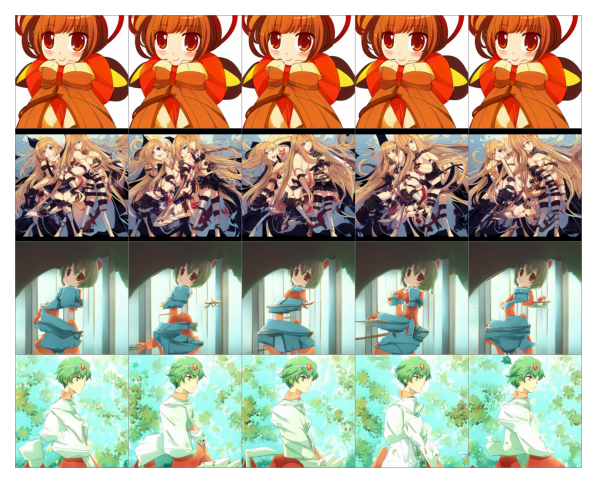

In [ ]:
gen = load_generator(
    args={
        'resolution': 512,
        'gan_type': 'StyleGAN2',
    },
    G_weights='/content/navigan/network-tadne.pt'
)

G = GeneratorWithWeightDeformator(
    generator=gen,
    deformator_type='hessian',
    layer_ix=3,
    eigenvectors_path='/content/navigan/hi_exp00_dir/eigenvectors.tmp.pt'
)

zs = torch.randn([4, 1024], device='cuda')
imgs = []
n_steps = 5
with torch.no_grad():
    for i_scale in np.arange(n_steps):
        scale = 2.0 * float(i_scale) / (n_steps - 1) - 1.
        G.deformate(0, scale)

        batch_size = 4
        imgs_batch = []
        for i in np.arange(0, len(zs), batch_size):
            imgs_batch.append(G(zs[i: i + batch_size]).cpu())

        imgs.append(torch.cat(imgs_batch))

imgs_grid = torch.cat([t for t in torch.stack(imgs).transpose(0, 1)])

plt.figure(figsize=(n_steps, len(zs)), dpi=150)
plt.axis('off')
plt.imshow(to_image_grid(torch.clamp(imgs_grid, -1, 1), nrow=n_steps))

# TADNE Editor - DeepDanbooru Dirs

In [ ]:
gdown.download('https://drive.google.com/uc?id=1x9cD_MV3UVboqnlpq9ZPWQ-kvFzxOGaz', 'deepdanbooru_dirs.pkl', quiet=False)